In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Activation, Convolution2D, Dropout, Conv2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [34]:
# 데이터 불러오기 

dataset_path = './fer2013test.csv'
image_size=(48,48)
 
def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        print(len(face))
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).values
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
print(faces)
print(emotions)
faces = preprocess_input(faces)
print(faces)

2304
[[[[ 70.]
   [ 80.]
   [ 82.]
   ...
   [ 52.]
   [ 43.]
   [ 41.]]

  [[ 65.]
   [ 61.]
   [ 58.]
   ...
   [ 56.]
   [ 52.]
   [ 44.]]

  [[ 50.]
   [ 43.]
   [ 54.]
   ...
   [ 49.]
   [ 56.]
   [ 47.]]

  ...

  [[ 91.]
   [ 65.]
   [ 42.]
   ...
   [ 72.]
   [ 56.]
   [ 43.]]

  [[ 77.]
   [ 82.]
   [ 79.]
   ...
   [105.]
   [ 70.]
   [ 46.]]

  [[ 77.]
   [ 72.]
   [ 84.]
   ...
   [106.]
   [109.]
   [ 82.]]]]
[[1]]
[[[[-0.45098037]
   [-0.372549  ]
   [-0.35686272]
   ...
   [-0.5921569 ]
   [-0.6627451 ]
   [-0.6784314 ]]

  [[-0.49019605]
   [-0.52156866]
   [-0.54509807]
   ...
   [-0.56078434]
   [-0.5921569 ]
   [-0.654902  ]]

  [[-0.60784316]
   [-0.6627451 ]
   [-0.5764706 ]
   ...
   [-0.6156863 ]
   [-0.56078434]
   [-0.6313726 ]]

  ...

  [[-0.2862745 ]
   [-0.49019605]
   [-0.67058825]
   ...
   [-0.4352941 ]
   [-0.56078434]
   [-0.6627451 ]]

  [[-0.3960784 ]
   [-0.35686272]
   [-0.38039213]
   ...
   [-0.17647058]
   [-0.45098037]
   [-0.6392157 ]]

  [[-

In [35]:
# 훈련데이터 셋과 테스트 데이터 셋 나누기

xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)
print(xtrain.shape, xtrain.dtype)
print(xtest.shape, xtest.dtype)

(0, 48, 48, 1) float32
(1, 48, 48, 1) float32


In [36]:
# 사용하는 파라미터 정리 

batch_size = 32
num_epochs = 110
input_shape = (48,48,1)
verbose = 1
num_classes = 7
patience = 50
base_path = './'
l2_regularization=0.01

In [37]:
# 데이터 생성

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

regularization = l2(l2_regularization)

In [38]:
# base

img_input = Input(input_shape)
x = Conv2D(8,(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8,(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

In [39]:
# module 1

residual = Conv2D(16,(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16,(3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16,(3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
x = layers.add([x, residual])

In [40]:
# module 2

residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

In [41]:
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

In [42]:
# module 4

residual = Conv2D(128,(1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

x = Conv2D(num_classes, (3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)

print(x)
output = Activation('softmax', name='predictions')(x)

print(output.shape)

Tensor("global_average_pooling2d_1/Mean:0", shape=(?, 7), dtype=float32)
(?, 7)


In [11]:
# model 

model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [12]:
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1, save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

In [27]:
# 훈련 시작 

xecption_history = model.fit_generator(data_generator.flow(xtrain, ytrain, batch_size),
                       steps_per_epoch=len(xtrain) / batch_size,
                       epochs=num_epochs, verbose=1, callbacks=callbacks,
                       validation_data=(xtest, ytest),initial_epoch=109)

Epoch 110/110
7178/7178 [==============================] - 38s 5ms/sample - loss: 1.4605 - acc: 0.4678

Epoch 00110: val_loss improved from 1.63602 to 1.46092, saving model to ./_mini_XCEPTION.110-0.467818.hdf5
898/898 [==============================] - 1481s 2s/step - loss: 1.5274 - acc: 0.4292 - val_loss: 1.4609 - val_acc: 0.4678


In [26]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import imutils
import cv2
import numpy as np
import sys
 
# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = './_mini_XCEPTION.110-0.471998.hdf5'
img_path = sys.argv[1]
 
# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]
 
#reading the frame
orig_frame = cv2.imread(img_path)
frame = cv2.imread(img_path,0)
faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
 
if len(faces) > 0:
    faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = faces
    roi = frame[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (48, 48))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
 

cv2.imshow('test_face', orig_frame)
cv2.imwrite('test_output/'+img_path.split('/')[-1],orig_frame)
if (cv2.waitKey(2000) & 0xFF == ord('q')):
    sys.exit("Thanks")
cv2.destroyAllWindows()

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\highgui\src\window.cpp:352: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


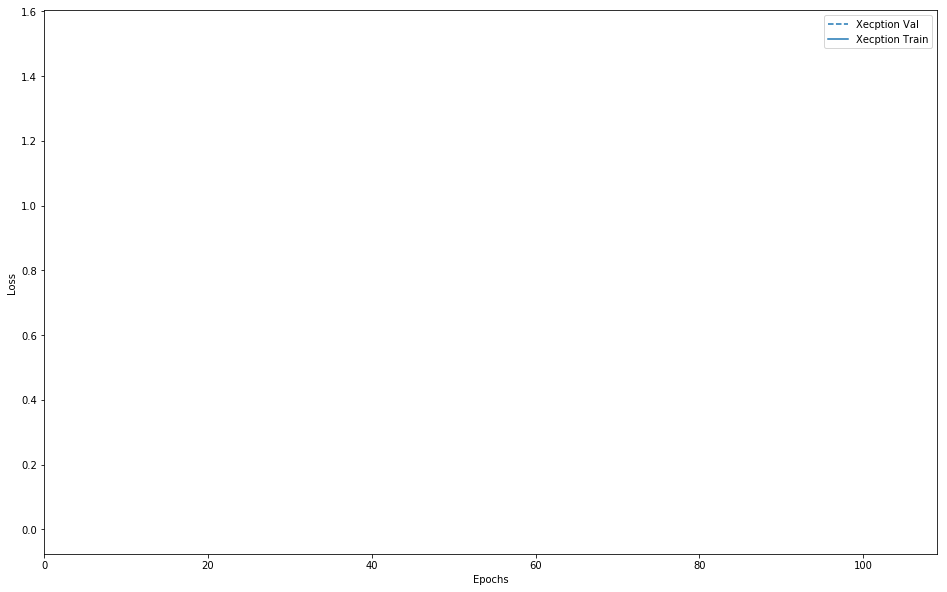

In [38]:
# 훈련 손실과 검증 손실 그래프 그리기 

## 실선 - 훈련손실 
## 점선 - 검증 손실 
    ### --> 낮은 검증 손실이 더 좋은 모델 
    
    
print(xecption_history.history.keys())
    

def plot_history(histories, key='loss'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['lr'],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('xecption', xecption_history)])
